In [18]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline
sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,8)})
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn import linear_model, naive_bayes, neighbors, svm, tree, ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
df = pd.read_csv("data/train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [21]:
df_dask = df.copy(deep=True)

In [22]:
def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Converts categorical variables to their appropriate type
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        the final dataframe with corrected categorical data types
    '''

    df_copy = df.copy(deep=True)
    df_copy['blue'] = df.blue.astype('category')
    df_copy['dual_sim'] = df.dual_sim.astype('category')
    df_copy['four_g'] = df.four_g.astype('category')
    df_copy['three_g'] = df.three_g.astype('category')
    df_copy['touch_screen'] = df.touch_screen.astype('category')
    df_copy['wifi'] = df.wifi.astype('category')
    return df_copy

In [23]:
def calc_skewness(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculates skewness and kurtosis of numeric features in the dataframe
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        result of skewness and kurtosis of each variable in the dataset as a pandas dataframe
    '''

    skew, kurtosis, num_features = [], [], []
    for feature in df.columns:
        if df[feature].dtype.name != 'category':
            num_features.append(feature)
            skew.append(round(df[feature].skew(), 2))
            kurtosis.append(round(df[feature].kurtosis(), 2))

    skew_analysis = pd.DataFrame(data={
        'skewness': skew,
        'kurtosis': kurtosis
    }, index=num_features)

    return skew_analysis

calc_skewness(df)

,skewness,kurtosis
battery_power,0.03,-1.22
blue,0.02,-2.00
clock_speed,0.18,-1.32
dual_sim,-0.04,-2.00
fc,1.02,0.28
four_g,-0.09,-1.99
int_memory,0.06,-1.22
m_dep,0.09,-1.27
mobile_wt,0.01,-1.21
n_cores,0.00,-1.23


1.2229124022462423 0.8597058041136045
0.17623988317251565


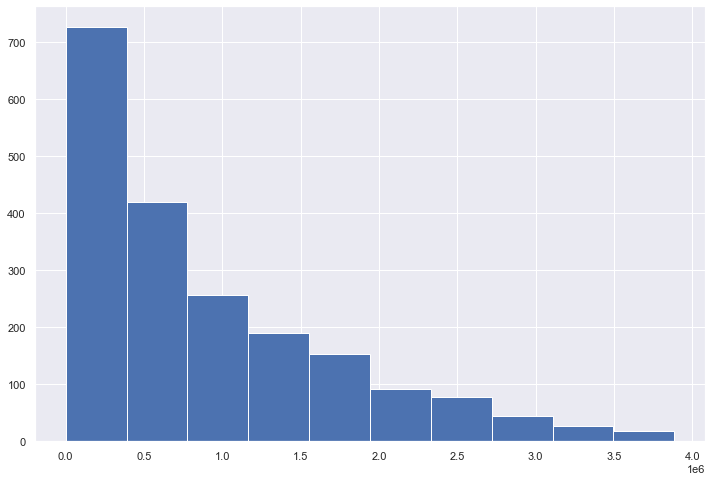

In [25]:
px_whole = df['px_width'] * df['px_height']
px_whole.hist()
print(px_whole.skew(), px_whole.kurtosis())
print(df['price_range'].corr(px_whole))

1.1650256696599273 0.7321893625628713
0.0412481385143414


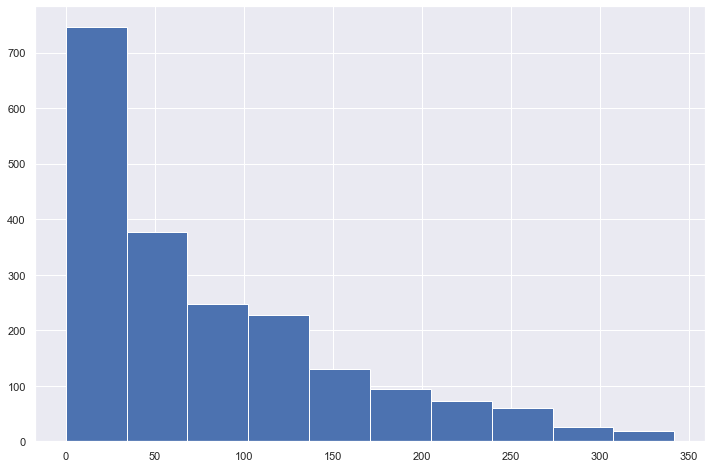

In [26]:
sc_whole = df['sc_w'] * df['sc_h']
sc_whole.hist()
print(sc_whole.skew(), sc_whole.kurtosis())
print(df['price_range'].corr(sc_whole))

In [27]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Extract features form the original dataset
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        the final dataframe with extracted features
    '''

    df_copy = df.copy(deep=True)
    df_copy['px_whole'] = px_whole
    df_copy['sc_whole'] = sc_whole
    df_copy.drop(['px_width', 'px_height', 'sc_h', 'sc_w'], axis=1, inplace=True)
    return df_copy

## Data Prepration

In [28]:
df_X = df.drop('price_range', axis=1)
df_y = df['price_range']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,test_size=0.2, stratify=df_y, random_state=42)
print("Train size: ", X_train.shape, y_train.shape)
print("Test size: ", X_test.shape, y_test.shape)

Train size:  (1600, 20) (1600,)
Test size:  (400, 20) (400,)


In [29]:
X_train = add_features(X_train)
X_test = add_features(X_test)

In [30]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [31]:
X_train = convert_types(X_train)
X_test = convert_types(X_test)

array([[<AxesSubplot:title={'center':'battery_power'}>,
        <AxesSubplot:title={'center':'clock_speed'}>,
        <AxesSubplot:title={'center':'fc'}>],
       [<AxesSubplot:title={'center':'int_memory'}>,
        <AxesSubplot:title={'center':'m_dep'}>,
        <AxesSubplot:title={'center':'mobile_wt'}>],
       [<AxesSubplot:title={'center':'n_cores'}>,
        <AxesSubplot:title={'center':'pc'}>,
        <AxesSubplot:title={'center':'ram'}>],
       [<AxesSubplot:title={'center':'talk_time'}>,
        <AxesSubplot:title={'center':'px_whole'}>,
        <AxesSubplot:title={'center':'sc_whole'}>]], dtype=object)

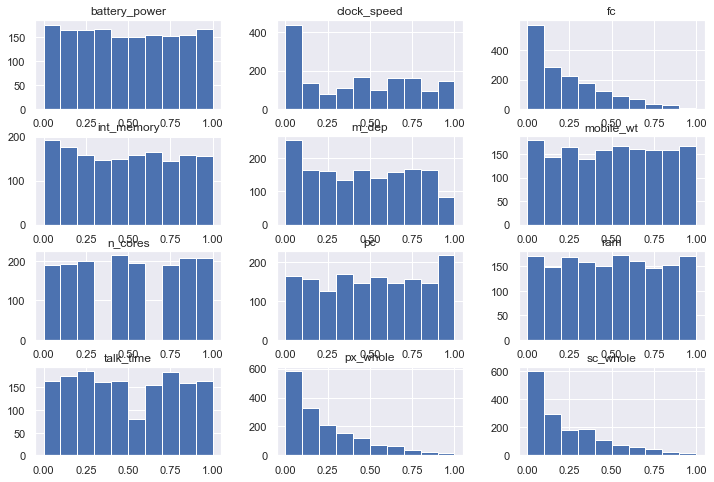

In [14]:
X_train.hist()

In [15]:
calc_skewness(X_train)

,skewness,kurtosis
battery_power,0.05,-1.22
clock_speed,0.16,-1.32
fc,1.03,0.33
int_memory,0.06,-1.24
m_dep,0.08,-1.29
mobile_wt,-0.00,-1.20
n_cores,-0.01,-1.23
pc,0.02,-1.18
ram,0.01,-1.19
talk_time,0.02,-1.22


In [32]:
def handle_skewed_distributions(df):
    '''
    Apply square root to the skewed variables
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        the final dataframe with corrected skewed features
    '''
    
    df_copy = df.copy(deep=True)
    df_copy['fc_sqrt'] = np.sqrt(df['fc'])
    df_copy['px_whole_sqrt'] = np.sqrt(df['px_whole'])
    df_copy['sc_whole_sqrt'] = np.sqrt(df['sc_whole'])
    df_copy.drop(['fc', 'px_whole', 'sc_whole'], inplace=True, axis=1)
    return df_copy

In [33]:
X_train_dask = X_train.copy(deep=True)

In [34]:
time_start = time.time()
X_train = handle_skewed_distributions(X_train)
print("Time: ", time.time() - time_start)
X_test = handle_skewed_distributions(X_test)
calc_skewness(X_train)

Time:  0.006524562835693359


,skewness,kurtosis
battery_power,0.05,-1.22
clock_speed,0.16,-1.32
int_memory,0.06,-1.24
m_dep,0.08,-1.29
mobile_wt,-0.00,-1.20
n_cores,-0.01,-1.23
pc,0.02,-1.18
ram,0.01,-1.19
talk_time,0.02,-1.22
fc_sqrt,0.01,-1.02


### Preprocessing using dask

In [35]:
import dask
import dask.dataframe as dd

In [38]:
times_dask = []
for npart in range(2, 10):
    dask_df = dd.from_pandas(X_train_dask, npartitions=npart)
    time_start = time.time()
    dask_df = dask_df.map_partitions(handle_skewed_distributions, meta=X_train).compute()
    times_dask.append(time.time() - time_start)

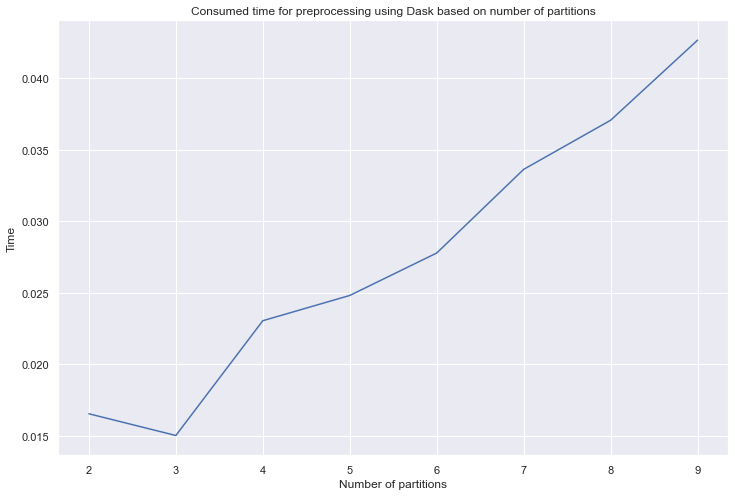

In [40]:
plt.plot(range(2, 10), times_dask)
plt.xticks(range(2, 10))
axis = plt.gca()
axis.set_xlabel("Number of partitions")
axis.set_ylabel("Time")
plt.title("Consumed time for preprocessing using Dask based on number of partitions")
plt.show()

In [41]:
min(times_dask)

0.015039682388305664

## Classification

In [83]:
models = [
    linear_model.LogisticRegressionCV(),
    linear_model.SGDClassifier(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    neighbors.KNeighborsClassifier(),
    svm.SVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
]

model_result_columns = ['Model Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Time']
model_result = pd.DataFrame(columns=model_result_columns)

cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0)

for index, model in enumerate(models):
    model_result.loc[index, 'Model Name'] = model.__class__.__name__
    model_result.loc[index, 'Parameters'] = str(model.get_params())

    cv_result = cross_validate(model, X_train, y_train, cv=cv_split, n_jobs=-1, return_train_score=True, scoring='f1_macro')
    
    model_result.loc[index, 'Time'] = cv_result['fit_time'].mean()
    model_result.loc[index, 'Train Accuracy Mean'] = cv_result['train_score'].mean()
    model_result.loc[index, 'Test Accuracy Mean'] = cv_result['test_score'].mean() 

model_result.sort_values(by=['Test Accuracy Mean'], ascending=False, inplace=True)
model_result

,Model Name,Parameters,Train Accuracy Mean,Test Accuracy Mean,Time
0,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}",0.961277,0.928198,2.41075
12,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",1.0,0.869574,1.400981
10,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}",0.991631,0.864902,0.066535
13,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}",1.0,0.84617,0.312132
11,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}",1.0,0.824523,0.251616
7,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",1.0,0.812194,0.01133
5,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}",0.952285,0.795388,0.449328
3,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.805487,0.786299,0.006718
6,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}",0.819666,0.766836,0.067783
1,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",0.737717,0.702661,0.028377


In [65]:
feature_importance_model = ensemble.RandomForestClassifier()
feature_importance_model.fit(X_train, y_train)
feature_importance_df = pd.DataFrame(data={
    'importance': feature_importance_model.feature_importances_
}, index=X_train.columns)
feature_importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance_df

,importance
ram,0.512116
battery_power,0.078575
px_whole_sqrt,0.077972
mobile_wt,0.043471
int_memory,0.038458
sc_whole_sqrt,0.037001
talk_time,0.032054
pc,0.031228
clock_speed,0.029981
m_dep,0.027100


In [54]:
param_grid_lgreg = [
    {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    },

    {
    'penalty': ['l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    },

    {
    'penalty': ['elasticnet'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['saga'],
    'l1_ratio': np.arange(0, 1, 0.01)
    }
]

tune_model_lgreg = GridSearchCV(linear_model.LogisticRegression(), param_grid=param_grid_lgreg,
                                      scoring='f1_macro', cv=10, n_jobs=4, return_train_score=True)
tune_model_lgreg.fit(X_train, y_train)

print("best parameters: ", tune_model_lgreg.best_params_)
print("Mean train score: ", tune_model_lgreg.cv_results_['mean_train_score'][tune_model_lgreg.best_index_] * 100)
print("Mean test Score: ", tune_model_lgreg.cv_results_['mean_test_score'][tune_model_lgreg.best_index_] * 100)

best parameters:  {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean train score:  95.8131447476761
Mean test Score:  93.86478964714166


C:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
param_grid_bagging = [
    {
    "base_estimator__max_depth": np.arange(10, 100, 10),
    "base_estimator__max_features": [None, "auto", "sqrt"],
    "base_estimator__min_samples_leaf": [1, 3, 5, 7, 10],
    "base_estimator__min_samples_split": np.arange(2, 10),
    "base_estimator__criterion": ["gini", "entropy"],
    'bootstrap_features': [False, True],
    'max_features': [0.5, 0.7, 1.0],
    'max_samples': [0.05, 0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1.0],
    'n_estimators': np.arange(200, 2000, 10)
    }
]

tune_model_bagging = RandomizedSearchCV(ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier()),
                                        param_distributions=param_grid_bagging, scoring='f1_macro', cv=5,
                                        n_jobs=4, n_iter=50, return_train_score=True)
tune_model_bagging.fit(X_train, y_train)

print("best parameters: ", tune_model_bagging.best_params_)
print("Mean train score: ", tune_model_bagging.cv_results_['mean_train_score'][tune_model_bagging.best_index_] * 100)
print("Mean test Score: ", tune_model_bagging.cv_results_['mean_test_score'][tune_model_bagging.best_index_] * 100)

best parameters:  {'n_estimators': 1080, 'max_samples': 0.75, 'max_features': 1.0, 'bootstrap_features': False, 'base_estimator__min_samples_split': 5, 'base_estimator__min_samples_leaf': 7, 'base_estimator__max_features': None, 'base_estimator__max_depth': 70, 'base_estimator__criterion': 'entropy'}
Mean train score:  94.92614166503579
Mean test Score:  88.11397739199573


In [43]:
param_grid_rf = [
    {
        'criterion': ['gini', 'entropy'],
        'n_estimators': np.arange(200, 2000, 10),
        'max_depth': np.arange(10, 100, 10),
        "min_samples_split": np.arange(2, 10),
        "min_samples_leaf": [1, 3, 5, 7, 10],
        "max_features": [None, "auto", "sqrt"],
        "bootstrap": [True, False],
        'max_samples': [0.05, 0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1.0]
    }
]

tune_model_rf = RandomizedSearchCV(ensemble.RandomForestClassifier(), n_iter=50,
                                   param_distributions=param_grid_rf, scoring='f1_macro',
                                   cv=5, n_jobs=4, return_train_score=True)
tune_model_rf.fit(X_train, y_train)

print("best parameters: ", tune_model_rf.best_params_)
print("Mean train score: ", tune_model_rf.cv_results_['mean_train_score'][tune_model_rf.best_index_] * 100)
print("Mean test Score: ", tune_model_rf.cv_results_['mean_test_score'][tune_model_rf.best_index_] * 100)

best parameters:  {'n_estimators': 440, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': None, 'max_depth': 60, 'criterion': 'entropy', 'bootstrap': True}
Mean train score:  96.40015831372125
Mean test Score:  88.62353340182787


In [58]:
param_grid_gbm = [
    {
        "max_depth": np.arange(10, 100, 10),
        "max_features": [None, "auto", "sqrt", "log2"],
        "min_samples_leaf": np.arange(2, 10),
        "min_samples_split": np.arange(2, 10),
        "criterion": ['friedman_mse', 'squared_error'],
        'n_estimators': np.arange(200, 2000, 10),
        'learning_rate': np.logspace(-3, 1, 20),
        'subsample':[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    }
]

tune_model_gbm = RandomizedSearchCV(ensemble.GradientBoostingClassifier(), n_iter=30,
                                   param_distributions=param_grid_gbm, scoring='f1_macro',
                                   cv=3, n_jobs=4, return_train_score=True)
tune_model_gbm.fit(X_train, y_train)

print("best parameters: ", tune_model_gbm.best_params_)
print("Mean train score: ", tune_model_gbm.cv_results_['mean_train_score'][tune_model_gbm.best_index_] * 100)
print("Mean test Score: ", tune_model_gbm.cv_results_['mean_test_score'][tune_model_gbm.best_index_] * 100)

best parameters:  {'subsample': 0.7, 'n_estimators': 730, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.011288378916846888, 'criterion': 'friedman_mse'}
Mean train score:  100.0
Mean test Score:  88.30661788898084


In [63]:
best_model = linear_model.LogisticRegressionCV(Cs=np.linspace(3600, 3900, 20), solver='lbfgs', penalty='l2')
best_model.fit(X_train, y_train)
y_hat = best_model.predict(X_train)
print(confusion_matrix(y_train, y_hat))
print(classification_report(y_train, y_hat))

[[394   6   0   0]
 [ 13 372  15   0]
 [  0  15 376   9]
 [  0   0   9 391]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.95      0.93      0.94       400
           2       0.94      0.94      0.94       400
           3       0.98      0.98      0.98       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



In [64]:
y_hat_test = best_model.predict(X_test)
print(confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

[[99  1  0  0]
 [ 3 93  4  0]
 [ 0  2 94  4]
 [ 0  0  5 95]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.97      0.93      0.95       100
           2       0.91      0.94      0.93       100
           3       0.96      0.95      0.95       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [72]:
def test_on_top_k_selected_features(k: int) -> None:
    '''
    Calculates performance of the final model on the to k selected features form the dataset
    Arguments:
        k is an integer which specify top k selected features
    '''

    important_features = feature_importance_df.head(k).index
    important_features
    X_train_important = X_train[important_features]
    X_test_important = X_test[important_features]
    
    print("--- Train ---")
    best_model_selected_features = linear_model.LogisticRegressionCV(Cs=np.linspace(3600, 3900, 20), solver='lbfgs', penalty='l2')
    best_model_selected_features.fit(X_train_important, y_train)
    y_hat = best_model_selected_features.predict(X_train_important)
    print(confusion_matrix(y_train, y_hat))
    print(classification_report(y_train, y_hat))

    print("--- TEST ---")
    y_hat_test = best_model_selected_features.predict(X_test_important)
    print(confusion_matrix(y_test, y_hat_test))
    print(classification_report(y_test, y_hat_test))

In [81]:
test_on_top_k_selected_features(6)

--- Train ---
[[390  10   0   0]
 [ 12 376  12   0]
 [  0  14 373  13]
 [  0   0   9 391]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       400
           1       0.94      0.94      0.94       400
           2       0.95      0.93      0.94       400
           3       0.97      0.98      0.97       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600

--- TEST ---
[[99  1  0  0]
 [ 1 95  4  0]
 [ 0  1 97  2]
 [ 0  0  4 96]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.98      0.95      0.96       100
           2       0.92      0.97      0.95       100
           3       0.98      0.96      0.97       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0